In [76]:
from covertrace.data_array import Sites
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import abspath, dirname, join
from scipy.integrate import odeint
from scipy.optimize import fmin

%matplotlib inline

In [77]:
from covertrace.utils.kinase_estimation_lmb import Estimator_h_ki_kv
from covertrace.utils.kinase_estimation_inh import fit_params_inhibitor

In [78]:
from covertrace import ops_filter
from covertrace import ops_plotter
from covertrace import ops_bool

In [79]:
data_folder = join(dirname(abspath(os.curdir)), 'covertrackdev', 'output')

Kcat and Km is taken from previous works. 

## Estimation of k<sub>v</sub>

First obtain the parameter kv, ratio of cytosolic volume to nuclear volume. 
k_v can be robustly estimated when the dynamic range of the translcoation is large. 
We use the contidition where JNK reporter is activated by anisomycin and then inhibited by JNK inhibitor. 


In [80]:
parent_folder = join(data_folder, 'AnisoInh')
sub_folders = ['Pos001', 'Pos002']
conditions = ['AnisoInh', 'AnisoInh']
sites = Sites(parent_folder, sub_folders, conditions, file_name='df_cleaned.npz')

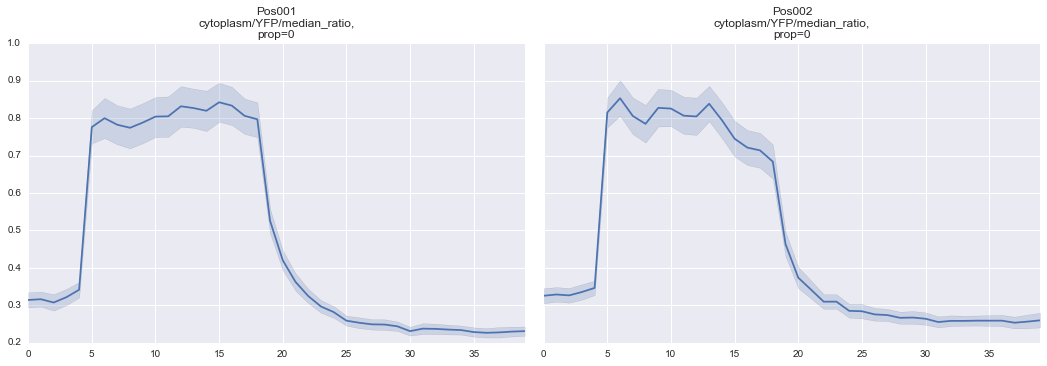

In [81]:
# Take a look at average traces for the cytoplasmic/nuclear ratio of median intensity. This is based on cleaned dataset.
sites.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
plot_tsplot = partial(ops_plotter.plot_tsplot)
fig, axes = sites.iterate(plot_tsplot)

In [7]:
# You see the cytoplasmic translocation of JNK KTR at frame 4 when cells are stimulated at anisomycin and 
# then nuclear translocation at frame 16 when they are inhibited with JNK IVV inhibitor. 
# This combination of activation and inactivation will provide a large dynamic range, helping robust parameter estimation. 

In [14]:
# Merge cells from two sites.
sites.merge_conditions()

Pos001: file_name is updated to arr_modified.npz


In [15]:
# NEED TO RESET THE FRAME. ASK JAKE. 
for site in sites:
    r_n_1 = np.nanmean(site.data['nuclei', 'YFP', 'median_intensity'][0])
    r_n_2 = np.nanmean(site.data['nuclei', 'YFP', 'median_intensity'][20])
    r_c_1 = np.nanmean(site.data['cytoplasm', 'YFP', 'median_intensity'][0])
    r_c_2 = np.nanmean(site.data['cytoplasm', 'YFP', 'median_intensity'][20])


In [16]:
estimated_k_v = np.nanmean((r_n_2 - r_n_1)/(r_c_1 - r_c_2))
print estimated_k_v

-1.56958827286


## Estimation of k<sub>iu</sub>, k<sub>eu</sub>, k<sub>ip</sub>, k<sub>ep</sub>

The cytoplasmic translocation of KTR happens because phosphorylation decreases the export rate and increases
the import rate. Thus we would like to know the import and export rate contants for both phosphorylated reporters and 
non-phosphorylated reporters. 
To estimate these constants, we utilize the fact that JNK KTR AA and JNK KTR EE mutants approximate the unphosphorylated 
and phosphorylated state of the wild-type JNK KTR, respectively. 

In [17]:
parent_folder_mut = join(data_folder, 'LMB')
sub_folders_mut = ['Pos003', 'Pos004', 'Pos005', 'Pos006']
conditions_mut = ['JNK_AA', 'JNK_AA', 'JNK_EE', 'JNK_EE']
sites_mut = Sites(parent_folder_mut, sub_folders_mut, conditions_mut, file_name='df_cleaned.npz')

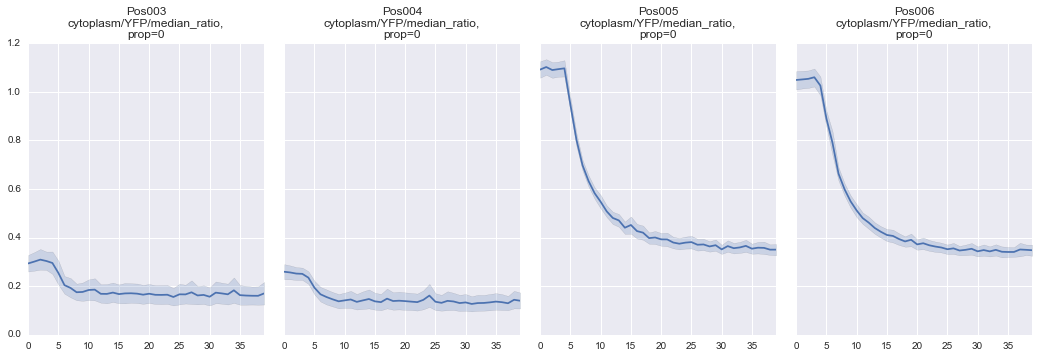

In [18]:
sites_mut.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
fig, axes = sites_mut.iterate(plot_tsplot)

In [23]:
# h can be potentially inferred by steady state rather than fitting. 
# pre_steady_state = sites_mut.Pos005.data.slice_arr[:, 1:5].mean(axis=1)
# post_steady_state = sites_mut.Pos005.data.slice_arr[:, 25:].mean(axis=1)

# estim_h = (post_steady_state/pre_steady_state).mean()  # Not clear
# print estim_h

In [24]:
sites_mut.merge_conditions()

Pos003: file_name is updated to arr_modified.npz


In [25]:
aa_ratio = sites_mut.Pos003.data['cytoplasm', 'YFP', 'median_ratio']
ee_ratio = sites_mut.Pos005.data['cytoplasm', 'YFP', 'median_ratio']

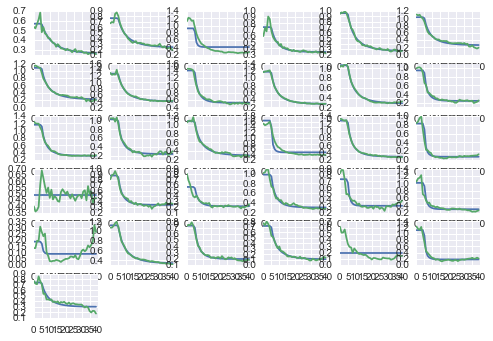

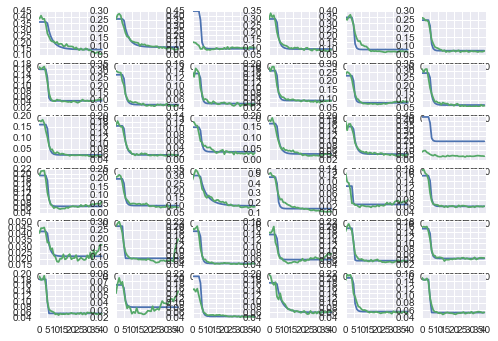

In [26]:
time = np.linspace(0, 20, 40) # Imaged every 30 sec
inh_timing = 2.5
ee_estimator = Estimator_h_ki_kv(time, ee_ratio, inh_timing, k_v=4.0)
h_ee, k_e_ee, k_i_ee, sim_ee = ee_estimator.estimate()
aa_estimator = Estimator_h_ki_kv(time, aa_ratio, inh_timing, k_v=4.0)
h_aa, k_e_aa, k_i_aa, sim_aa = aa_estimator.estimate()


In [27]:
k_ip = np.median(k_i_ee)
k_iu = np.median(k_i_aa)
k_ep = np.median(k_e_ee)
k_eu = np.median(k_e_aa)
print k_ip, k_iu, k_ep, k_eu

0.173033929649 1.61078730797 0.177305528672 0.289337370044


## Estimation of k<sub>du</sub>, k<sub>dn</sub>, K<sub>md</sub>

In [28]:
'''
k_dc = 0.03  # uM/min, dephosphorylation Vmax of reporter in cytosol
k_dn = 0.03  # uM/min, dephosphorylation Vmax of reporter in nucleus
Kmd = 0.1  # uM, Michaelis constant for dephosphorylation of reporter
We use the estimated k_iu, k_eu, k_ip and k_ep. 
'''

'\nk_dc = 0.03  # uM/min, dephosphorylation Vmax of reporter in cytosol\nk_dn = 0.03  # uM/min, dephosphorylation Vmax of reporter in nucleus\nKmd = 0.1  # uM, Michaelis constant for dephosphorylation of reporter\nWe use the estimated k_iu, k_eu, k_ip and k_ep. \n'

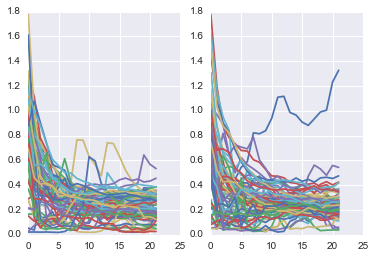

In [82]:
for num, site in enumerate(sites):
    plt.subplot(1, len(sites), num+1)
    plt.plot(site.data['cytoplasm', 'YFP', 'median_ratio'][:, 18:].T)

In [83]:
# Define a parameter set from the previous analysis. 
param_set = dict(k_v=4, k_iu=0.44, k_eu=0.11, k_ip=0.16, k_ep=0.2,
                 k_cat=20, Km=3, k_dc=0.03, k_dn=0.03, Kmd=0.1, r_total=0.4)

In [84]:
ts_time = np.arange(15)
ts_cn = np.exp(-0.3*np.arange(15))
x0 = np.random.random(3)
ret_store = []
# for i in range(3):
x0 = np.random.random(3)
ret = fit_params_inhibitor(x0, ts_time, ts_cn, param_set)
print ret

[ 0.58936291  0.3318314   0.50625845]


## Absolute kinase concentration

In [85]:
parent_folder = join(data_folder, 'IL1B')
sub_folders = ['Pos005', 'Pos006', 'Pos007', 'Pos008']
conditions = ['IL1B', 'IL1B', 'IL1B', 'IL1B']
sites_il1b = Sites(parent_folder, sub_folders, conditions, file_name='df_cleaned.npz')

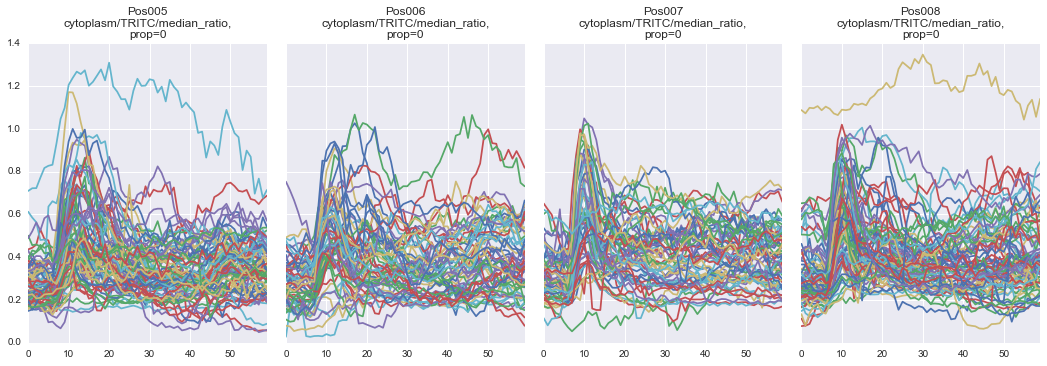

In [87]:
sites_il1b.staged.state = ['cytoplasm', 'TRITC', 'median_ratio']
plot_all = partial(ops_plotter.plot_all)
fig, axes = sites_il1b.iterate(plot_all)

(60,)

In [88]:
from covertrace.utils.kinase_estimation_dynamics import fit_trapezoid
from covertrace.utils.kinase_estimation_dynamics import fit_params_kinase_dynamics
from covertrace.utils.kinase_estimation_dynamics import kinase_dynamics_ode_rcn
from covertrace.utils.kinase_estimation_dynamics import construct_ts_from_trap_params

In [191]:
time = np.arange(0, 150, 2.5)  # in minute
time = np.arange(0, 15000, 250)  # in minute

fir_cell = sites_il1b.Pos006.data['cytoplasm', 'TRITC', 'median_ratio'][3, :]

2999.997581759113

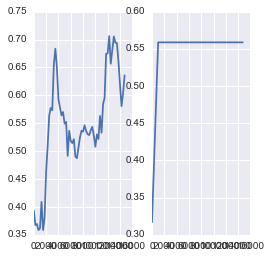

In [207]:
# Fit trapezoid.
trap_params = fit_trapezoid(time, fir_cell, p0=[0, 1000, 2000, 4000, 0, 2, 1])
ts_fit = construct_ts_from_trap_params(time, *trap_params)
plt.subplot(1,3,1)
plt.plot(time, fir_cell)
plt.subplot(1,3,2)
plt.plot(time, ts_fit)

In [169]:
k1, k2, k3 = fit_params_kinase_dynamics(trap_params, param_set, time)
rcn_predicted = kinase_dynamics_ode_rcn((k1, k2, k3), time, param_set, trap_params)
t1, t2, t3, t4 = trap_param[:4]
kinase_ts = construct_ts_from_trap_params(time, t1, t2, t3, t4, k1, k2, k3)

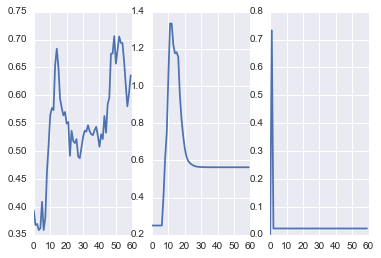

In [170]:
plt.subplot(1,3,1)
plt.plot(fir_cell)
plt.subplot(1,3,2)
plt.plot(rcn_predicted)
plt.subplot(1, 3,3)
plt.plot(kinase_ts)

4.3971386308026466